# Class-Adaptive Data Augmentation for Image Classification
### Purpose
While label-preserving property, class-specific augmentation(class별 적응형 augmentation 적용) through an optimization procedure to maximize the degree of transformation

- Data Augmentation 을 수행한 image가 다른 class를 갖게 된다면 오히려 해당 성능을 떨어지게 만들 수 있음
- 해당 연구는 Domain knowledge가 부족한 상태에서도, same manner가 아닌 class-adaptive augmentation을 수행하는 방법을 고안함
- Digit image 기반인 MINST and SVHN dataset을 통해 해당 연구를 수행함

해당 연구에서는 실험 senario로 세 가지 stage를 제안함<br>
stage_1) CNN training withhout data augmentation<br>
stage_2) optimization of class-specific augmentation polices while label-preserving property<br>
stage_3) CNN re-training with class-adaptive data augmentation

### Various Traditional Augmentation
1) Geometric transformation operations by changing the pixel positions<br>
2) Rotation, shifting, zooming, shearing, and flipping<br>
3) Photometric transformation - 각 색상에 대한 pixel 값을 변경(밝기 조절 포함)<br>
4) Combining two existing images, such as Mixup, CutMix, CutPaste

해당 연구에서는 1), 3) 대한 augmentation을 통해서 class-specific augmentation을 수행

\* 각 방식에 대한 참고. https://lcyking.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A6%9D%EA%B0%95Data-Augmentation

The distribution determines the degree of transformation of the image(분포에 따라서 이미지의 변형 정도를 선택)<br>
too narrow - data augmentation의 효과를 뚜렷하게 확인할 수 없음<br>
too broad - class-preserving이 어려움<br>
즉, 적절한 분포를 선택하지 않으면 오히려 negative effect를 유발할 수 있음

최근 연구들은 이러한 분포에 대한 세팅을 automatically 설정하는 것에 집중

기존 연구들의 search space of an augmentation policy and hyperparameter에 대한 설정은 dataset-level 과 instance-level로 나뉜다

1) dataset-level approach<br>
- 주어진 데이터셋 전체에 대해 최적화되도록 증강 정책을 수립

2) instance-level approach<br>
- each instance(input)에 대해서 image-specific augmentation을 적용

이와 다르게 해당 연구에서는 class-specific augmentation policy를 수립<br>
기존 연구 방법과 다르게 방향이 가지는 차별점

1) dataset-level approach<br>
- class-preserving 상태에서 다양한 transformation을 적용할 수 있음

2) instance-level approach<br>
- single CNN을 사용함으로써 network cost의 최소화(memory)

### Methology
- 수식을 통한 구체적인 이해를 위해 Notion에 따로 정리하였음<br>
https://www.notion.so/Class-Adaptive-Data-Augmentation-for-Image-Classification-247d8518abea80e58c58cd03ca3264b6


### Experiments
dataset
- MNIST
- SVHN
- WM-811K 에 대해 진행 

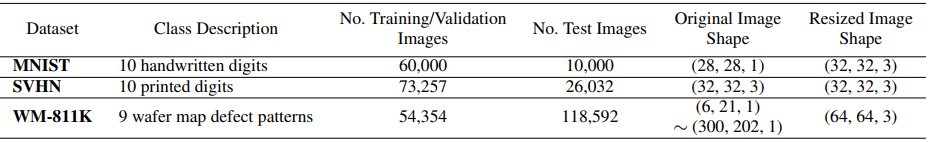

**CNN 구조**
- VGG19(Batch Normalization 적용) / ResNet34 적용
- 두 모델 모두 완전연결층(fully-connected layer 제거)
- 출력층(Output layer)는 클래스 수에 맞게 노드 개수 설정
- VGG19의 경우 Flatten 대신 Global Average Pooling 적용

### Train 설정
**Stage_1**
- Train:Validation = 8:2
- Loss 함수: Categorical Cross-Entropy
- Optimizer: Adam
- Mini-batch size: 128
- L2 Regularization e^-4
- Augmentation decay gamma: 0.98
- Initial Learning rate: e^-4
- LR 감소 조건 -> Validation accuracy가 25 epoch 동안 향상이 없을 시 0.1 배로 감소
- Early Stopping 조건<br>
 1) 총 100 epoch 이후, validation accurcy가 50 epoch 동안 향상 없으면 종료<br>
 2) 또는 최대 500 epoch 도달 시 종료

**Stage_2**
- Table 1에 들어있는 10개의 transformation을 진행
- 초기 epsilon = 0.1 / lambda = 0.01 로 설정
- Bayesian Optimization
    - surrogate model: Gaussian Process + Matern kernel
    - Acuquistion function: Expected Improvement
    - 초기 랜덤 탐색 5회 + 최적화 단계 30회

**성능 평가**
- 지표: Test Set Classification Accuracy
- 모든 실험은 랜덤 시드 다르게 10회 독립 반복
- 결과는 평균 +- 표준편차로 보고 
- DatasetAdaptive-DA(ablaiton)/Without-DA/Baseline-DA/ClassAdaptive-DA 에 대한 비교를 통한 결과 제시

In [19]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random

from sklearn.model_selection import train_test_split
from torchvision import models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

### Early Stopping

In [20]:
# Early-Stopping 정의
# 1. 100 epoch 이후, validation accuracy가 50 epoch 동안 향상 없으면 종료 patience = 50
# 2. 최대 500 epoch 도달 시 종료

class EarlyStopping():
    def __init__(self, patience=50, verbose=False, delta=0, max_epoch = 500, path = ""):
        self.patience = patience # 성능 향상 관련 epoch 종료 기준
        self.verbose = verbose # epoch 별 결과 출력 여부
        self.delta = delta # 최소 향상 지표
        self.counter = 0  # 성능 미향상 epoch 횟수
        self.t_counter = 0 # 전체 epoch 횟수
        self.max_epoch = max_epoch
        self.best_score = None
        self.early_stop = False # 조기 종료 여부
        self.path = path # 모델을 저장할 경로
    
    def __call__(self, val_acc, model): # Early-stopping 평가 기준: Validation Accuracy
        self.t_counter += 1
        score = val_acc

        if self.t_counter == self.max_epoch: # max_epoch 넘어갈 시 학습 종료 / 해당 실험에서는 max_epoch = 500
            self.early_stop = True

        elif self.t_counter <= 100: # 100 epoch까지는 아래 조건을 적용하지 않고 무조건 진행 
            self.best_score = score if self.best_score is None else max(self.best_score, score)
            self.save_checkpoint(model)

        elif self.best_score is None: # 최초 학습 시
            self.best_score = score
            self.save_checkpoint(model)

        elif score <= self.best_score + self.delta: # 성능 최소 향상 기준 미충족 시
            self.counter += 1

            if self.counter == self.patience:
                self.early_stop = True
            
        else:
            self.counter = 0
            self.best_score = score
            self.save_checkpoint(model)


    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Validation Accuracy increased. Saving model')
        torch.save(model.state_dict(), self.path)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
# 각 결과값은 채널 수에 따라 튜플로 제공

def compute_mean_std(dataset, unbiased = False):
    loader = DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=2) # 데이터셋이 큰 경우, 효율적인 데이터 로드와 계산을 위해 배치 사이즈 설정
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_pixels = 0

    for images, _ in loader:
        # images: [B, C, H, W] ([배치 사이즈, 채널 수, Height, Width])
        batch_samples = images.size(0)
        total_pixels += batch_samples * images.size(2) * images.size(3)
        
        mean += images.sum(dim=[0, 2, 3])  # 채널 별로 픽셀 합계를 누적
        std += (images ** 2).sum(dim=[0, 2, 3])  # 채널 별로 픽셀값^2 값을 누적

    mean /= total_pixels

    if unbiased:
        # 표본분산: Var = (E[x^2] - E[x]^2) * n / (n - 1)
        var = (std / total_pixels - mean ** 2) * (total_pixels / (total_pixels - 1))
    else:
        # 모분산: Var = E[x^2] - E[x]^2
        var = std / total_pixels - mean ** 2

    std = var.sqrt()

    return mean, std

### Data
1. MNIST
- 10 handwritten digits(0~9)
- Resized Image Shape (28,28,1) -> (32,32,3)

2. SVHN
- 10 printed digits(0~9)
- Resized Image Shape (32,32,3) -> (32,32,3)

3. WM-811K
- 9 wafer map defect patterns
- Resized Image Shape (6,21,1)~(300,202,1) -> (64,64,3)

In [23]:
# MNIST
m_fulltrainset = datasets.MNIST(root = './data', train=True, download=True, transform=transforms.ToTensor())
m_testset = datasets.MNIST(root = './data', train=False, download=True, transform=transforms.ToTensor())
m_fulltrainset, m_testset

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 142kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.18MB/s]


KeyboardInterrupt: 

In [ ]:
m_trainidx, m_validx = train_test_split(list(range(len(m_fulltrainset))), test_size = 0.2, random_state=42, shuffle = True, stratify=m_fulltrainset.targets) # Train:Val=8:2
m_trainset = Subset(m_fulltrainset, m_trainidx)
m_valset = Subset(m_fulltrainset, m_validx)

In [ ]:
m_mean, m_std = compute_mean_std(m_trainset)
m_mean, m_std

(tensor([0.1308, 0.1308, 0.1308]), tensor([0.3082, 0.3082, 0.3082]))

In [ ]:
m_transform = transforms.Compose([
    transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        m_mean, m_std
    )
])

m_fulltrainset = datasets.MNIST(root = './data', train=True, download=True, transform=m_transform)
m_testset = datasets.MNIST(root = './data', train=False, download=True, transform=m_transform)
m_trainidx, m_validx = train_test_split(list(range(len(m_fulltrainset))), test_size = 0.2, random_state=42, shuffle = True, stratify=m_fulltrainset.targets) # Train:Val=8:2
m_trainset = Subset(m_fulltrainset, m_trainidx)
m_valset = Subset(m_fulltrainset, m_validx)

In [ ]:
# mini-batch size = 128로 설정
m_trainloader = DataLoader(m_trainset, batch_size=128, shuffle=True, num_workers=2) 
m_valloader = DataLoader(m_valset, batch_size=128, shuffle=True, num_workers=2)
m_testloader = DataLoader(m_testset, batch_size=128, shuffle=True, num_workers=2)

### Model
1. VGG19_CNN
- batch normalization 적용
- fully-connected layer 제거
- output layer 클래스 수에 맞게 노드 개수 설정
- flatten 대신 global average pooling 적용

2. ResNet34_CNN
- fully-connected layer 제거
- output layer 클래스 수에 맞게 노드 개수 설정

In [ ]:
# VGG19_CNN
class VGG19_GAP(nn.Module):
    def __init__(self, num_classes):
        super(VGG19_GAP, self).__init__()
        # VGG19 with BatchNorm 불러오기
        self.base = models.vgg19_bn(weights="IMAGENET1K_V1")  # 사전학습 가중치
        # FC 제거
        self.base.classifier = nn.Identity()
        # Flatten 대신 Global Average Pooling + FC
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)  # VGG19 마지막 conv 출력 채널 = 512

    def forward(self, x):
        x = self.base.features(x)   # feature extractor
        x = self.gap(x)             # Global Average Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = self.fc(x)              # Output layer
        return x

In [ ]:
# ResNet34_CNN
class ResNet34_mod(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34_mod, self).__init__()
        self.base = models.resnet34(weights="IMAGENET1K_V1")
        # 기존 FC 제거
        self.base.fc = nn.Linear(self.base.fc.in_features, num_classes)

    def forward(self, x):
        return self.base(x)

### LR decay Loss Function & Optimizer
- 25 training epoch 동안 validation accuracy가 향상되지 않으면, 0.1배로 decay
- Loss Function: Adam
- L2 Regularization with a factor 1e^-4<br>
https://wikidocs.net/195132

In [ ]:
# VGG19
vgg19_model_m = VGG19_GAP(num_classes=len(m_fulltrainset.classes))
vgg19_num_ftrs_m = vgg19_model_m.fc.in_features
vgg19_model_m = vgg19_model_m.to(device)

# ResNet34
resnet34_model_m = ResNet34_mod(num_classes=len(m_fulltrainset.classes))
resnet34_num_ftrs_m = resnet34_model_m.base.fc.in_features
resnet34_model_m = resnet34_model_m.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
vgg19_optimizer_m = optim.Adam(vgg19_model_m.parameters(), lr = 1e-3, weight_decay=1e-4)
resnet34_optimizer_m = optim.Adam(resnet34_model_m.parameters(), lr = 1e-3, weight_decay=1e-4)
vgg19_scheduler_m = optim.lr_scheduler.ReduceLROnPlateau(vgg19_optimizer_m, mode='max', factor=0.1, patience=25, cooldown=0, verbose=True)
resnet34_scheduler_m = optim.lr_scheduler.ReduceLROnPlateau(resnet34_optimizer_m, mode='max', factor=0.1, patience=25, cooldown=0, verbose=True)

C:\Users\dm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Stage 1. CNN training without data augmentation

In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=500, model_path="best_model.pth"):
    early_stopping = EarlyStopping(
        patience=50, verbose=True, delta=0,
        max_epoch=num_epochs, path=model_path
    )

    # 기록 리스트
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # train
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(m_trainloader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in m_valloader:  # ← 오타 수정 (vallodaer → valloader)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= total
        val_acc = 100. * correct / total

        # 기록 저장
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Scheduler & Early Stopping
        scheduler.step(val_acc)
        early_stopping(val_acc, model)

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
              f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 저장된 Best Model 로드
    model.load_state_dict(torch.load(model_path))

    # 학습 기록 반환
    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    return model, history


def plot_history(history):
    """train/val loss & acc 그래프 그리기"""
    plt.figure(figsize=(10,6))
    epochs_range = range(1, len(history["train_losses"])+1)

    # Loss
    plt.plot(epochs_range, history["train_losses"], 'r-', label="Train Loss")
    plt.plot(epochs_range, history["val_losses"], 'r--', label="Val Loss")

    # Accuracy
    plt.plot(epochs_range, history["train_accuracies"], 'b-', label="Train Acc")
    plt.plot(epochs_range, history["val_accuracies"], 'b--', label="Val Acc")

    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    plt.title("Training & Validation Loss/Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

[Epoch 1/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s]


Validation Accuracy increased. Saving model
[Epoch 1] Train Loss: 0.1222, Train Acc: 96.97% | Val Loss: 0.0618, Val Acc: 98.53%


[Epoch 2/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.80it/s]


Validation Accuracy increased. Saving model
[Epoch 2] Train Loss: 0.0622, Train Acc: 98.59% | Val Loss: 0.0535, Val Acc: 98.83%


[Epoch 3/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.40it/s]


Validation Accuracy increased. Saving model
[Epoch 3] Train Loss: 0.0580, Train Acc: 98.65% | Val Loss: 0.1855, Val Acc: 95.65%


[Epoch 4/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s]


Validation Accuracy increased. Saving model
[Epoch 4] Train Loss: 0.0527, Train Acc: 98.80% | Val Loss: 0.0724, Val Acc: 98.26%


[Epoch 5/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.33it/s]


Validation Accuracy increased. Saving model
[Epoch 5] Train Loss: 0.0480, Train Acc: 98.94% | Val Loss: 0.1011, Val Acc: 98.00%


[Epoch 6/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.57it/s]


Validation Accuracy increased. Saving model
[Epoch 6] Train Loss: 0.0435, Train Acc: 99.00% | Val Loss: 0.0473, Val Acc: 98.98%


[Epoch 7/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.58it/s]


Validation Accuracy increased. Saving model
[Epoch 7] Train Loss: 0.0381, Train Acc: 99.13% | Val Loss: 0.0637, Val Acc: 98.46%


[Epoch 8/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.65it/s]


Validation Accuracy increased. Saving model
[Epoch 8] Train Loss: 0.0439, Train Acc: 99.00% | Val Loss: 0.0681, Val Acc: 98.65%


[Epoch 9/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.59it/s]


Validation Accuracy increased. Saving model
[Epoch 9] Train Loss: 0.0391, Train Acc: 99.11% | Val Loss: 0.0525, Val Acc: 98.87%


[Epoch 10/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.72it/s]


Validation Accuracy increased. Saving model
[Epoch 10] Train Loss: 0.0302, Train Acc: 99.33% | Val Loss: 0.0417, Val Acc: 99.05%


[Epoch 11/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.56it/s]


Validation Accuracy increased. Saving model
[Epoch 11] Train Loss: 0.0342, Train Acc: 99.25% | Val Loss: 0.0434, Val Acc: 99.09%


[Epoch 12/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.76it/s]


Validation Accuracy increased. Saving model
[Epoch 12] Train Loss: 0.0295, Train Acc: 99.35% | Val Loss: 0.0559, Val Acc: 98.77%


[Epoch 13/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.61it/s]


Validation Accuracy increased. Saving model
[Epoch 13] Train Loss: 0.0274, Train Acc: 99.38% | Val Loss: 0.0400, Val Acc: 99.10%


[Epoch 14/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.67it/s]


Validation Accuracy increased. Saving model
[Epoch 14] Train Loss: 0.0256, Train Acc: 99.45% | Val Loss: 0.0382, Val Acc: 99.18%


[Epoch 15/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.33it/s]


Validation Accuracy increased. Saving model
[Epoch 15] Train Loss: 0.0237, Train Acc: 99.48% | Val Loss: 0.0467, Val Acc: 98.95%


[Epoch 16/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.76it/s]


Validation Accuracy increased. Saving model
[Epoch 16] Train Loss: 0.0239, Train Acc: 99.44% | Val Loss: 0.0626, Val Acc: 98.69%


[Epoch 17/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.55it/s]


Validation Accuracy increased. Saving model
[Epoch 17] Train Loss: 0.0223, Train Acc: 99.51% | Val Loss: 0.0380, Val Acc: 99.13%


[Epoch 18/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.38it/s]


Validation Accuracy increased. Saving model
[Epoch 18] Train Loss: 0.0163, Train Acc: 99.61% | Val Loss: 0.0410, Val Acc: 99.04%


[Epoch 19/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.40it/s]


Validation Accuracy increased. Saving model
[Epoch 19] Train Loss: 0.0189, Train Acc: 99.56% | Val Loss: 0.0462, Val Acc: 99.06%


[Epoch 20/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.71it/s]


Validation Accuracy increased. Saving model
[Epoch 20] Train Loss: 0.0178, Train Acc: 99.56% | Val Loss: 0.0350, Val Acc: 99.23%


[Epoch 21/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.62it/s]


Validation Accuracy increased. Saving model
[Epoch 21] Train Loss: 0.0167, Train Acc: 99.59% | Val Loss: 0.0377, Val Acc: 99.17%


[Epoch 22/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.92it/s]


Validation Accuracy increased. Saving model
[Epoch 22] Train Loss: 0.0145, Train Acc: 99.67% | Val Loss: 0.0523, Val Acc: 98.82%


[Epoch 23/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.75it/s]


Validation Accuracy increased. Saving model
[Epoch 23] Train Loss: 0.0156, Train Acc: 99.61% | Val Loss: 0.0329, Val Acc: 99.26%


[Epoch 24/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.49it/s]


Validation Accuracy increased. Saving model
[Epoch 24] Train Loss: 0.0158, Train Acc: 99.60% | Val Loss: 0.0418, Val Acc: 99.04%


[Epoch 25/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s]


Validation Accuracy increased. Saving model
[Epoch 25] Train Loss: 0.0132, Train Acc: 99.69% | Val Loss: 0.0551, Val Acc: 98.91%


[Epoch 26/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.47it/s]


Validation Accuracy increased. Saving model
[Epoch 26] Train Loss: 0.0132, Train Acc: 99.68% | Val Loss: 0.0557, Val Acc: 98.86%


[Epoch 27/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.49it/s]


Validation Accuracy increased. Saving model
[Epoch 27] Train Loss: 0.0138, Train Acc: 99.66% | Val Loss: 0.0300, Val Acc: 99.32%


[Epoch 28/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.84it/s]


Validation Accuracy increased. Saving model
[Epoch 28] Train Loss: 0.0114, Train Acc: 99.73% | Val Loss: 0.0311, Val Acc: 99.26%


[Epoch 29/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.73it/s]


Validation Accuracy increased. Saving model
[Epoch 29] Train Loss: 0.0114, Train Acc: 99.71% | Val Loss: 0.0376, Val Acc: 99.18%


[Epoch 30/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.91it/s]


Validation Accuracy increased. Saving model
[Epoch 30] Train Loss: 0.0112, Train Acc: 99.73% | Val Loss: 0.0458, Val Acc: 98.95%


[Epoch 31/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.70it/s]


Validation Accuracy increased. Saving model
[Epoch 31] Train Loss: 0.0149, Train Acc: 99.66% | Val Loss: 0.0337, Val Acc: 99.21%


[Epoch 32/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.49it/s]


Validation Accuracy increased. Saving model
[Epoch 32] Train Loss: 0.0075, Train Acc: 99.82% | Val Loss: 0.0372, Val Acc: 99.19%


[Epoch 33/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.91it/s]


Validation Accuracy increased. Saving model
[Epoch 33] Train Loss: 0.0138, Train Acc: 99.68% | Val Loss: 0.0403, Val Acc: 99.16%


[Epoch 34/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.88it/s]


Validation Accuracy increased. Saving model
[Epoch 34] Train Loss: 0.0098, Train Acc: 99.77% | Val Loss: 0.0357, Val Acc: 99.18%


[Epoch 35/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.42it/s]


Validation Accuracy increased. Saving model
[Epoch 35] Train Loss: 0.0108, Train Acc: 99.74% | Val Loss: 0.0413, Val Acc: 99.06%


[Epoch 36/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.45it/s]


Validation Accuracy increased. Saving model
[Epoch 36] Train Loss: 0.0121, Train Acc: 99.69% | Val Loss: 0.0391, Val Acc: 99.17%


[Epoch 37/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.80it/s]


Validation Accuracy increased. Saving model
[Epoch 37] Train Loss: 0.0082, Train Acc: 99.80% | Val Loss: 0.0349, Val Acc: 99.23%


[Epoch 38/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.69it/s]


Validation Accuracy increased. Saving model
[Epoch 38] Train Loss: 0.0105, Train Acc: 99.72% | Val Loss: 0.0425, Val Acc: 99.03%


[Epoch 39/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.80it/s]


Validation Accuracy increased. Saving model
[Epoch 39] Train Loss: 0.0081, Train Acc: 99.80% | Val Loss: 0.0396, Val Acc: 99.17%


[Epoch 40/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.44it/s]


Validation Accuracy increased. Saving model
[Epoch 40] Train Loss: 0.0090, Train Acc: 99.75% | Val Loss: 0.0429, Val Acc: 99.12%


[Epoch 41/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.50it/s]


Validation Accuracy increased. Saving model
[Epoch 41] Train Loss: 0.0116, Train Acc: 99.71% | Val Loss: 0.0312, Val Acc: 99.26%


[Epoch 42/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.65it/s]


Validation Accuracy increased. Saving model
[Epoch 42] Train Loss: 0.0089, Train Acc: 99.76% | Val Loss: 0.0398, Val Acc: 99.14%


[Epoch 43/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.00it/s]


Validation Accuracy increased. Saving model
[Epoch 43] Train Loss: 0.0077, Train Acc: 99.81% | Val Loss: 0.0516, Val Acc: 98.97%


[Epoch 44/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.96it/s]


Validation Accuracy increased. Saving model
[Epoch 44] Train Loss: 0.0067, Train Acc: 99.83% | Val Loss: 0.0570, Val Acc: 98.83%


[Epoch 45/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.03it/s]


Validation Accuracy increased. Saving model
[Epoch 45] Train Loss: 0.0123, Train Acc: 99.71% | Val Loss: 0.0453, Val Acc: 99.00%


[Epoch 46/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.82it/s]


Validation Accuracy increased. Saving model
[Epoch 46] Train Loss: 0.0090, Train Acc: 99.76% | Val Loss: 0.0377, Val Acc: 99.14%


[Epoch 47/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.58it/s]


Validation Accuracy increased. Saving model
[Epoch 47] Train Loss: 0.0080, Train Acc: 99.78% | Val Loss: 0.0321, Val Acc: 99.25%


[Epoch 48/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s]


Validation Accuracy increased. Saving model
[Epoch 48] Train Loss: 0.0066, Train Acc: 99.83% | Val Loss: 0.0370, Val Acc: 99.22%


[Epoch 49/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.27it/s]


Validation Accuracy increased. Saving model
[Epoch 49] Train Loss: 0.0076, Train Acc: 99.82% | Val Loss: 0.0383, Val Acc: 99.18%


[Epoch 50/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.17it/s]


Validation Accuracy increased. Saving model
[Epoch 50] Train Loss: 0.0070, Train Acc: 99.84% | Val Loss: 0.0439, Val Acc: 99.00%


[Epoch 51/500] Training: 100%|██████████| 375/375 [00:19<00:00, 18.88it/s]


Validation Accuracy increased. Saving model
[Epoch 51] Train Loss: 0.0105, Train Acc: 99.74% | Val Loss: 0.0415, Val Acc: 99.12%


[Epoch 52/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.45it/s]


Validation Accuracy increased. Saving model
[Epoch 52] Train Loss: 0.0078, Train Acc: 99.82% | Val Loss: 0.0355, Val Acc: 99.24%


[Epoch 53/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.47it/s]


Validation Accuracy increased. Saving model
[Epoch 53] Train Loss: 0.0087, Train Acc: 99.77% | Val Loss: 0.0345, Val Acc: 99.17%


[Epoch 54/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.71it/s]


Validation Accuracy increased. Saving model
[Epoch 54] Train Loss: 0.0034, Train Acc: 99.92% | Val Loss: 0.0264, Val Acc: 99.46%


[Epoch 55/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.54it/s]


Validation Accuracy increased. Saving model
[Epoch 55] Train Loss: 0.0015, Train Acc: 99.98% | Val Loss: 0.0259, Val Acc: 99.43%


[Epoch 56/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.50it/s]


Validation Accuracy increased. Saving model
[Epoch 56] Train Loss: 0.0014, Train Acc: 99.98% | Val Loss: 0.0279, Val Acc: 99.44%


[Epoch 57/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.50it/s]


Validation Accuracy increased. Saving model
[Epoch 57] Train Loss: 0.0009, Train Acc: 99.99% | Val Loss: 0.0266, Val Acc: 99.47%


[Epoch 58/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.37it/s]


Validation Accuracy increased. Saving model
[Epoch 58] Train Loss: 0.0007, Train Acc: 99.99% | Val Loss: 0.0266, Val Acc: 99.45%


[Epoch 59/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.63it/s]


Validation Accuracy increased. Saving model
[Epoch 59] Train Loss: 0.0006, Train Acc: 99.99% | Val Loss: 0.0253, Val Acc: 99.47%


[Epoch 60/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.67it/s]


Validation Accuracy increased. Saving model
[Epoch 60] Train Loss: 0.0006, Train Acc: 99.99% | Val Loss: 0.0256, Val Acc: 99.52%


[Epoch 61/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.42it/s]


Validation Accuracy increased. Saving model
[Epoch 61] Train Loss: 0.0005, Train Acc: 99.99% | Val Loss: 0.0261, Val Acc: 99.53%


[Epoch 62/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.58it/s]


Validation Accuracy increased. Saving model
[Epoch 62] Train Loss: 0.0004, Train Acc: 99.99% | Val Loss: 0.0267, Val Acc: 99.50%


[Epoch 63/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.37it/s]


Validation Accuracy increased. Saving model
[Epoch 63] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0266, Val Acc: 99.52%


[Epoch 64/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.38it/s]


Validation Accuracy increased. Saving model
[Epoch 64] Train Loss: 0.0004, Train Acc: 99.99% | Val Loss: 0.0308, Val Acc: 99.43%


[Epoch 65/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.63it/s]


Validation Accuracy increased. Saving model
[Epoch 65] Train Loss: 0.0004, Train Acc: 99.99% | Val Loss: 0.0284, Val Acc: 99.46%


[Epoch 66/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.57it/s]


Validation Accuracy increased. Saving model
[Epoch 66] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0279, Val Acc: 99.47%


[Epoch 67/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.75it/s]


Validation Accuracy increased. Saving model
[Epoch 67] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0296, Val Acc: 99.43%


[Epoch 68/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.54it/s]


Validation Accuracy increased. Saving model
[Epoch 68] Train Loss: 0.0006, Train Acc: 99.99% | Val Loss: 0.0279, Val Acc: 99.53%


[Epoch 69/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.70it/s]


Validation Accuracy increased. Saving model
[Epoch 69] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0290, Val Acc: 99.50%


[Epoch 70/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.68it/s]


Validation Accuracy increased. Saving model
[Epoch 70] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0298, Val Acc: 99.49%


[Epoch 71/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.42it/s]


Validation Accuracy increased. Saving model
[Epoch 71] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0305, Val Acc: 99.48%


[Epoch 72/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.38it/s]


Validation Accuracy increased. Saving model
[Epoch 72] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0284, Val Acc: 99.53%


[Epoch 73/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.78it/s]


Validation Accuracy increased. Saving model
[Epoch 73] Train Loss: 0.0004, Train Acc: 99.99% | Val Loss: 0.0334, Val Acc: 99.42%


[Epoch 74/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.57it/s]


Validation Accuracy increased. Saving model
[Epoch 74] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0300, Val Acc: 99.48%


[Epoch 75/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.86it/s]


Validation Accuracy increased. Saving model
[Epoch 75] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0313, Val Acc: 99.45%


[Epoch 76/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.27it/s]


Validation Accuracy increased. Saving model
[Epoch 76] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.37%


[Epoch 77/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.77it/s]


Validation Accuracy increased. Saving model
[Epoch 77] Train Loss: 0.0005, Train Acc: 99.99% | Val Loss: 0.0356, Val Acc: 99.42%


[Epoch 78/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.73it/s]


Validation Accuracy increased. Saving model
[Epoch 78] Train Loss: 0.0006, Train Acc: 99.99% | Val Loss: 0.0359, Val Acc: 99.40%


[Epoch 79/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.74it/s]


Validation Accuracy increased. Saving model
[Epoch 79] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0357, Val Acc: 99.43%


[Epoch 80/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.63it/s]


Validation Accuracy increased. Saving model
[Epoch 80] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0346, Val Acc: 99.46%


[Epoch 81/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.49it/s]


Validation Accuracy increased. Saving model
[Epoch 81] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0347, Val Acc: 99.47%


[Epoch 82/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.88it/s]


Validation Accuracy increased. Saving model
[Epoch 82] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0369, Val Acc: 99.50%


[Epoch 83/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.56it/s]


Validation Accuracy increased. Saving model
[Epoch 83] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0364, Val Acc: 99.48%


[Epoch 84/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.38it/s]


Validation Accuracy increased. Saving model
[Epoch 84] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0355, Val Acc: 99.47%


[Epoch 85/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.74it/s]


Validation Accuracy increased. Saving model
[Epoch 85] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0349, Val Acc: 99.47%


[Epoch 86/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.72it/s]


Validation Accuracy increased. Saving model
[Epoch 86] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0362, Val Acc: 99.45%


[Epoch 87/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.75it/s]


Validation Accuracy increased. Saving model
[Epoch 87] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0372, Val Acc: 99.45%


[Epoch 88/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.64it/s]


Validation Accuracy increased. Saving model
[Epoch 88] Train Loss: 0.0008, Train Acc: 99.98% | Val Loss: 0.0350, Val Acc: 99.43%


[Epoch 89/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.54it/s]


Validation Accuracy increased. Saving model
[Epoch 89] Train Loss: 0.0013, Train Acc: 99.97% | Val Loss: 0.0385, Val Acc: 99.39%


[Epoch 90/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s]


Validation Accuracy increased. Saving model
[Epoch 90] Train Loss: 0.0008, Train Acc: 99.99% | Val Loss: 0.0339, Val Acc: 99.45%


[Epoch 91/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.63it/s]


Validation Accuracy increased. Saving model
[Epoch 91] Train Loss: 0.0005, Train Acc: 99.99% | Val Loss: 0.0348, Val Acc: 99.44%


[Epoch 92/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.71it/s]


Validation Accuracy increased. Saving model
[Epoch 92] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0343, Val Acc: 99.47%


[Epoch 93/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s]


Validation Accuracy increased. Saving model
[Epoch 93] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0381, Val Acc: 99.42%


[Epoch 94/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.46it/s]


Validation Accuracy increased. Saving model
[Epoch 94] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0360, Val Acc: 99.44%


[Epoch 95/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.67it/s]


Validation Accuracy increased. Saving model
[Epoch 95] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0364, Val Acc: 99.47%


[Epoch 96/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.33it/s]


Validation Accuracy increased. Saving model
[Epoch 96] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0383, Val Acc: 99.43%


[Epoch 97/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.70it/s]


Validation Accuracy increased. Saving model
[Epoch 97] Train Loss: 0.0012, Train Acc: 99.98% | Val Loss: 0.0348, Val Acc: 99.42%


[Epoch 98/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.42it/s]


Validation Accuracy increased. Saving model
[Epoch 98] Train Loss: 0.0006, Train Acc: 99.99% | Val Loss: 0.0352, Val Acc: 99.40%


[Epoch 99/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.22it/s]


Validation Accuracy increased. Saving model
[Epoch 99] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0348, Val Acc: 99.42%


[Epoch 100/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.31it/s]


Validation Accuracy increased. Saving model
[Epoch 100] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0351, Val Acc: 99.42%


[Epoch 101/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s]


[Epoch 101] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0349, Val Acc: 99.40%


[Epoch 102/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.31it/s]


[Epoch 102] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.42%


[Epoch 103/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.08it/s]


[Epoch 103] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0348, Val Acc: 99.42%


[Epoch 104/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.21it/s]


[Epoch 104] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0349, Val Acc: 99.42%


[Epoch 105/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.65it/s]


[Epoch 105] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0347, Val Acc: 99.43%


[Epoch 106/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.66it/s]


[Epoch 106] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0344, Val Acc: 99.43%


[Epoch 107/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.64it/s]


[Epoch 107] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0345, Val Acc: 99.44%


[Epoch 108/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.50it/s]


[Epoch 108] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0352, Val Acc: 99.44%


[Epoch 109/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.70it/s]


[Epoch 109] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0348, Val Acc: 99.44%


[Epoch 110/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.71it/s]


[Epoch 110] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0350, Val Acc: 99.44%


[Epoch 111/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.63it/s]


[Epoch 111] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0352, Val Acc: 99.47%


[Epoch 112/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.77it/s]


[Epoch 112] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0365, Val Acc: 99.46%


[Epoch 113/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.66it/s]


[Epoch 113] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.47%


[Epoch 114/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s]


[Epoch 114] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.42%


[Epoch 115/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s]


[Epoch 115] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0345, Val Acc: 99.46%


[Epoch 116/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.06it/s]


[Epoch 116] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0348, Val Acc: 99.44%


[Epoch 117/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.44it/s]


[Epoch 117] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0352, Val Acc: 99.44%


[Epoch 118/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.63it/s]


[Epoch 118] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0351, Val Acc: 99.43%


[Epoch 119/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.51it/s]


[Epoch 119] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0358, Val Acc: 99.46%


[Epoch 120/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.67it/s]


[Epoch 120] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0352, Val Acc: 99.42%


[Epoch 121/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.80it/s]


[Epoch 121] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.43%


[Epoch 122/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.81it/s]


[Epoch 122] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0360, Val Acc: 99.43%


[Epoch 123/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.63it/s]


[Epoch 123] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0352, Val Acc: 99.44%


[Epoch 124/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.91it/s]


[Epoch 124] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0355, Val Acc: 99.43%


[Epoch 125/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.97it/s]


[Epoch 125] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.42%


[Epoch 126/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s]


[Epoch 126] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.42%


[Epoch 127/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.85it/s]


[Epoch 127] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.48%


[Epoch 128/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.17it/s]


[Epoch 128] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0359, Val Acc: 99.46%


[Epoch 129/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.91it/s]


[Epoch 129] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0353, Val Acc: 99.43%


[Epoch 130/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.69it/s]


[Epoch 130] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.44%


[Epoch 131/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s]


[Epoch 131] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.44%


[Epoch 132/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.51it/s]


[Epoch 132] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0355, Val Acc: 99.43%


[Epoch 133/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.86it/s]


[Epoch 133] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0355, Val Acc: 99.45%


[Epoch 134/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.92it/s]


[Epoch 134] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0351, Val Acc: 99.44%


[Epoch 135/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.06it/s]


[Epoch 135] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0353, Val Acc: 99.42%


[Epoch 136/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.29it/s]


[Epoch 136] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.42%


[Epoch 137/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.72it/s]


[Epoch 137] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0355, Val Acc: 99.42%


[Epoch 138/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.80it/s]


[Epoch 138] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0360, Val Acc: 99.46%


[Epoch 139/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.70it/s]


[Epoch 139] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0348, Val Acc: 99.42%


[Epoch 140/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.59it/s]


[Epoch 140] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0355, Val Acc: 99.47%


[Epoch 141/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.64it/s]


[Epoch 141] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0358, Val Acc: 99.46%


[Epoch 142/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.63it/s]


[Epoch 142] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0350, Val Acc: 99.42%


[Epoch 143/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.14it/s]


[Epoch 143] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0356, Val Acc: 99.45%


[Epoch 144/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.56it/s]


[Epoch 144] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0354, Val Acc: 99.42%


[Epoch 145/500] Training: 100%|██████████| 375/375 [00:16<00:00, 23.13it/s]


[Epoch 145] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0360, Val Acc: 99.48%


[Epoch 146/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.86it/s]


[Epoch 146] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0357, Val Acc: 99.45%


[Epoch 147/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.57it/s]


[Epoch 147] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0353, Val Acc: 99.45%


[Epoch 148/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.58it/s]


[Epoch 148] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0349, Val Acc: 99.44%


[Epoch 149/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.81it/s]


[Epoch 149] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0356, Val Acc: 99.46%


[Epoch 150/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.81it/s]


[Epoch 150] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0351, Val Acc: 99.45%
Early stopping triggered


[Epoch 1/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.76it/s]


Validation Accuracy increased. Saving model
[Epoch 1] Train Loss: 0.1224, Train Acc: 96.55% | Val Loss: 0.0561, Val Acc: 98.53%


[Epoch 2/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.42it/s]


Validation Accuracy increased. Saving model
[Epoch 2] Train Loss: 0.0479, Train Acc: 98.64% | Val Loss: 0.0431, Val Acc: 98.72%


[Epoch 3/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.78it/s]


Validation Accuracy increased. Saving model
[Epoch 3] Train Loss: 0.0369, Train Acc: 98.95% | Val Loss: 0.0812, Val Acc: 97.71%


[Epoch 4/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.79it/s]


Validation Accuracy increased. Saving model
[Epoch 4] Train Loss: 0.0342, Train Acc: 99.02% | Val Loss: 0.0561, Val Acc: 98.47%


[Epoch 5/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.18it/s]


Validation Accuracy increased. Saving model
[Epoch 5] Train Loss: 0.0269, Train Acc: 99.24% | Val Loss: 0.0423, Val Acc: 98.80%


[Epoch 6/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.07it/s]


Validation Accuracy increased. Saving model
[Epoch 6] Train Loss: 0.0288, Train Acc: 99.20% | Val Loss: 0.0423, Val Acc: 98.87%


[Epoch 7/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.86it/s]


Validation Accuracy increased. Saving model
[Epoch 7] Train Loss: 0.0258, Train Acc: 99.28% | Val Loss: 0.0431, Val Acc: 98.90%


[Epoch 8/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.00it/s]


Validation Accuracy increased. Saving model
[Epoch 8] Train Loss: 0.0258, Train Acc: 99.25% | Val Loss: 0.0356, Val Acc: 99.05%


[Epoch 9/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.98it/s]


Validation Accuracy increased. Saving model
[Epoch 9] Train Loss: 0.0216, Train Acc: 99.36% | Val Loss: 0.0649, Val Acc: 98.33%


[Epoch 10/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.96it/s]


Validation Accuracy increased. Saving model
[Epoch 10] Train Loss: 0.0222, Train Acc: 99.38% | Val Loss: 0.0325, Val Acc: 99.07%


[Epoch 11/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.27it/s]


Validation Accuracy increased. Saving model
[Epoch 11] Train Loss: 0.0206, Train Acc: 99.42% | Val Loss: 0.0427, Val Acc: 98.84%


[Epoch 12/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.75it/s]


Validation Accuracy increased. Saving model
[Epoch 12] Train Loss: 0.0181, Train Acc: 99.48% | Val Loss: 0.0584, Val Acc: 98.45%


[Epoch 13/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.00it/s]


Validation Accuracy increased. Saving model
[Epoch 13] Train Loss: 0.0192, Train Acc: 99.47% | Val Loss: 0.0325, Val Acc: 99.15%


[Epoch 14/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.19it/s]


Validation Accuracy increased. Saving model
[Epoch 14] Train Loss: 0.0179, Train Acc: 99.53% | Val Loss: 0.0314, Val Acc: 99.12%


[Epoch 15/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.05it/s]


Validation Accuracy increased. Saving model
[Epoch 15] Train Loss: 0.0184, Train Acc: 99.45% | Val Loss: 0.0307, Val Acc: 99.21%


[Epoch 16/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.32it/s]


Validation Accuracy increased. Saving model
[Epoch 16] Train Loss: 0.0158, Train Acc: 99.56% | Val Loss: 0.0319, Val Acc: 99.09%


[Epoch 17/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.86it/s]


Validation Accuracy increased. Saving model
[Epoch 17] Train Loss: 0.0147, Train Acc: 99.59% | Val Loss: 0.0353, Val Acc: 99.06%


[Epoch 18/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.98it/s]


Validation Accuracy increased. Saving model
[Epoch 18] Train Loss: 0.0136, Train Acc: 99.58% | Val Loss: 0.0401, Val Acc: 99.03%


[Epoch 19/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.91it/s]


Validation Accuracy increased. Saving model
[Epoch 19] Train Loss: 0.0137, Train Acc: 99.58% | Val Loss: 0.0407, Val Acc: 99.05%


[Epoch 20/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.83it/s]


Validation Accuracy increased. Saving model
[Epoch 20] Train Loss: 0.0108, Train Acc: 99.69% | Val Loss: 0.0553, Val Acc: 98.61%


[Epoch 21/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.47it/s]


Validation Accuracy increased. Saving model
[Epoch 21] Train Loss: 0.0139, Train Acc: 99.61% | Val Loss: 0.0349, Val Acc: 99.14%


[Epoch 22/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.11it/s]


Validation Accuracy increased. Saving model
[Epoch 22] Train Loss: 0.0131, Train Acc: 99.59% | Val Loss: 0.0408, Val Acc: 98.96%


[Epoch 23/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.85it/s]


Validation Accuracy increased. Saving model
[Epoch 23] Train Loss: 0.0099, Train Acc: 99.71% | Val Loss: 0.0354, Val Acc: 99.15%


[Epoch 24/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.64it/s]


Validation Accuracy increased. Saving model
[Epoch 24] Train Loss: 0.0100, Train Acc: 99.71% | Val Loss: 0.0417, Val Acc: 98.93%


[Epoch 25/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s]


Validation Accuracy increased. Saving model
[Epoch 25] Train Loss: 0.0139, Train Acc: 99.59% | Val Loss: 0.0516, Val Acc: 98.78%


[Epoch 26/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.76it/s]


Validation Accuracy increased. Saving model
[Epoch 26] Train Loss: 0.0090, Train Acc: 99.72% | Val Loss: 0.0351, Val Acc: 99.07%


[Epoch 27/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.87it/s]


Validation Accuracy increased. Saving model
[Epoch 27] Train Loss: 0.0112, Train Acc: 99.68% | Val Loss: 0.0318, Val Acc: 99.13%


[Epoch 28/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.30it/s]


Validation Accuracy increased. Saving model
[Epoch 28] Train Loss: 0.0091, Train Acc: 99.72% | Val Loss: 0.0489, Val Acc: 98.70%


[Epoch 29/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.38it/s]


Validation Accuracy increased. Saving model
[Epoch 29] Train Loss: 0.0086, Train Acc: 99.71% | Val Loss: 0.0418, Val Acc: 98.92%


[Epoch 30/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.89it/s]


Validation Accuracy increased. Saving model
[Epoch 30] Train Loss: 0.0102, Train Acc: 99.71% | Val Loss: 0.0423, Val Acc: 98.97%


[Epoch 31/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.69it/s]


Validation Accuracy increased. Saving model
[Epoch 31] Train Loss: 0.0080, Train Acc: 99.75% | Val Loss: 0.0425, Val Acc: 98.93%


[Epoch 32/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.77it/s]


Validation Accuracy increased. Saving model
[Epoch 32] Train Loss: 0.0090, Train Acc: 99.73% | Val Loss: 0.0416, Val Acc: 98.88%


[Epoch 33/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.95it/s]


Validation Accuracy increased. Saving model
[Epoch 33] Train Loss: 0.0080, Train Acc: 99.75% | Val Loss: 0.0434, Val Acc: 98.92%


[Epoch 34/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.29it/s]


Validation Accuracy increased. Saving model
[Epoch 34] Train Loss: 0.0091, Train Acc: 99.72% | Val Loss: 0.0387, Val Acc: 99.07%


[Epoch 35/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.99it/s]


Validation Accuracy increased. Saving model
[Epoch 35] Train Loss: 0.0072, Train Acc: 99.80% | Val Loss: 0.0380, Val Acc: 99.01%


[Epoch 36/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.94it/s]


Validation Accuracy increased. Saving model
[Epoch 36] Train Loss: 0.0081, Train Acc: 99.77% | Val Loss: 0.0391, Val Acc: 98.97%


[Epoch 37/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.17it/s]


Validation Accuracy increased. Saving model
[Epoch 37] Train Loss: 0.0083, Train Acc: 99.75% | Val Loss: 0.0437, Val Acc: 98.94%


[Epoch 38/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.92it/s]


Validation Accuracy increased. Saving model
[Epoch 38] Train Loss: 0.0081, Train Acc: 99.77% | Val Loss: 0.0416, Val Acc: 98.97%


[Epoch 39/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.70it/s]


Validation Accuracy increased. Saving model
[Epoch 39] Train Loss: 0.0076, Train Acc: 99.78% | Val Loss: 0.0405, Val Acc: 99.07%


[Epoch 40/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.61it/s]


Validation Accuracy increased. Saving model
[Epoch 40] Train Loss: 0.0071, Train Acc: 99.80% | Val Loss: 0.0407, Val Acc: 99.02%


[Epoch 41/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.45it/s]


Validation Accuracy increased. Saving model
[Epoch 41] Train Loss: 0.0082, Train Acc: 99.78% | Val Loss: 0.0362, Val Acc: 99.09%


[Epoch 42/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.77it/s]


Validation Accuracy increased. Saving model
[Epoch 42] Train Loss: 0.0038, Train Acc: 99.91% | Val Loss: 0.0259, Val Acc: 99.33%


[Epoch 43/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.51it/s]


Validation Accuracy increased. Saving model
[Epoch 43] Train Loss: 0.0013, Train Acc: 99.98% | Val Loss: 0.0239, Val Acc: 99.38%


[Epoch 44/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.49it/s]


Validation Accuracy increased. Saving model
[Epoch 44] Train Loss: 0.0009, Train Acc: 100.00% | Val Loss: 0.0245, Val Acc: 99.38%


[Epoch 45/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.39it/s]


Validation Accuracy increased. Saving model
[Epoch 45] Train Loss: 0.0007, Train Acc: 99.99% | Val Loss: 0.0248, Val Acc: 99.38%


[Epoch 46/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.02it/s]


Validation Accuracy increased. Saving model
[Epoch 46] Train Loss: 0.0007, Train Acc: 99.99% | Val Loss: 0.0242, Val Acc: 99.38%


[Epoch 47/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.16it/s]


Validation Accuracy increased. Saving model
[Epoch 47] Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0238, Val Acc: 99.41%


[Epoch 48/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.77it/s]


Validation Accuracy increased. Saving model
[Epoch 48] Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0245, Val Acc: 99.41%


[Epoch 49/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.73it/s]


Validation Accuracy increased. Saving model
[Epoch 49] Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0238, Val Acc: 99.45%


[Epoch 50/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.61it/s]


Validation Accuracy increased. Saving model
[Epoch 50] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0240, Val Acc: 99.43%


[Epoch 51/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.06it/s]


Validation Accuracy increased. Saving model
[Epoch 51] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0253, Val Acc: 99.40%


[Epoch 52/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.57it/s]


Validation Accuracy increased. Saving model
[Epoch 52] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0243, Val Acc: 99.43%


[Epoch 53/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.34it/s]


Validation Accuracy increased. Saving model
[Epoch 53] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0243, Val Acc: 99.44%


[Epoch 54/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.44it/s]


Validation Accuracy increased. Saving model
[Epoch 54] Train Loss: 0.0006, Train Acc: 99.99% | Val Loss: 0.0246, Val Acc: 99.43%


[Epoch 55/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.49it/s]


Validation Accuracy increased. Saving model
[Epoch 55] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0261, Val Acc: 99.38%


[Epoch 56/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.68it/s]


Validation Accuracy increased. Saving model
[Epoch 56] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0263, Val Acc: 99.39%


[Epoch 57/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.81it/s]


Validation Accuracy increased. Saving model
[Epoch 57] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0258, Val Acc: 99.42%


[Epoch 58/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.78it/s]


Validation Accuracy increased. Saving model
[Epoch 58] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0277, Val Acc: 99.39%


[Epoch 59/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.03it/s]


Validation Accuracy increased. Saving model
[Epoch 59] Train Loss: 0.0007, Train Acc: 99.99% | Val Loss: 0.0279, Val Acc: 99.35%


[Epoch 60/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.87it/s]


Validation Accuracy increased. Saving model
[Epoch 60] Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0282, Val Acc: 99.34%


[Epoch 61/500] Training: 100%|██████████| 375/375 [00:18<00:00, 19.84it/s]


Validation Accuracy increased. Saving model
[Epoch 61] Train Loss: 0.0006, Train Acc: 99.99% | Val Loss: 0.0283, Val Acc: 99.35%


[Epoch 62/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.32it/s]


Validation Accuracy increased. Saving model
[Epoch 62] Train Loss: 0.0007, Train Acc: 99.99% | Val Loss: 0.0297, Val Acc: 99.28%


[Epoch 63/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.05it/s]


Validation Accuracy increased. Saving model
[Epoch 63] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0297, Val Acc: 99.31%


[Epoch 64/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.21it/s]


Validation Accuracy increased. Saving model
[Epoch 64] Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0305, Val Acc: 99.32%


[Epoch 65/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.92it/s]


Validation Accuracy increased. Saving model
[Epoch 65] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0309, Val Acc: 99.27%


[Epoch 66/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.35it/s]


Validation Accuracy increased. Saving model
[Epoch 66] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0308, Val Acc: 99.31%


[Epoch 67/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.81it/s]


Validation Accuracy increased. Saving model
[Epoch 67] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0296, Val Acc: 99.35%


[Epoch 68/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.68it/s]


Validation Accuracy increased. Saving model
[Epoch 68] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0313, Val Acc: 99.35%


[Epoch 69/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.93it/s]


Validation Accuracy increased. Saving model
[Epoch 69] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0295, Val Acc: 99.42%


[Epoch 70/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.68it/s]


Validation Accuracy increased. Saving model
[Epoch 70] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0301, Val Acc: 99.40%


[Epoch 71/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.92it/s]


Validation Accuracy increased. Saving model
[Epoch 71] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0311, Val Acc: 99.38%


[Epoch 72/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.35it/s]


Validation Accuracy increased. Saving model
[Epoch 72] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0298, Val Acc: 99.38%


[Epoch 73/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.75it/s]


Validation Accuracy increased. Saving model
[Epoch 73] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0318, Val Acc: 99.33%


[Epoch 74/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.10it/s]


Validation Accuracy increased. Saving model
[Epoch 74] Train Loss: 0.0017, Train Acc: 99.96% | Val Loss: 0.0339, Val Acc: 99.24%


[Epoch 75/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.60it/s]


Validation Accuracy increased. Saving model
[Epoch 75] Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.27%


[Epoch 76/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.89it/s]


Validation Accuracy increased. Saving model
[Epoch 76] Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0324, Val Acc: 99.30%


[Epoch 77/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.82it/s]


Validation Accuracy increased. Saving model
[Epoch 77] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0335, Val Acc: 99.28%


[Epoch 78/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.71it/s]


Validation Accuracy increased. Saving model
[Epoch 78] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0331, Val Acc: 99.29%


[Epoch 79/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.31it/s]


Validation Accuracy increased. Saving model
[Epoch 79] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.30%


[Epoch 80/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.68it/s]


Validation Accuracy increased. Saving model
[Epoch 80] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.28%


[Epoch 81/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.24it/s]


Validation Accuracy increased. Saving model
[Epoch 81] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.30%


[Epoch 82/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.01it/s]


Validation Accuracy increased. Saving model
[Epoch 82] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0325, Val Acc: 99.28%


[Epoch 83/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.80it/s]


Validation Accuracy increased. Saving model
[Epoch 83] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0327, Val Acc: 99.31%


[Epoch 84/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.80it/s]


Validation Accuracy increased. Saving model
[Epoch 84] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0325, Val Acc: 99.29%


[Epoch 85/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.92it/s]


Validation Accuracy increased. Saving model
[Epoch 85] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0328, Val Acc: 99.31%


[Epoch 86/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.49it/s]


Validation Accuracy increased. Saving model
[Epoch 86] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0336, Val Acc: 99.30%


[Epoch 87/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.01it/s]


Validation Accuracy increased. Saving model
[Epoch 87] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0327, Val Acc: 99.32%


[Epoch 88/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.94it/s]


Validation Accuracy increased. Saving model
[Epoch 88] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0326, Val Acc: 99.30%


[Epoch 89/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.85it/s]


Validation Accuracy increased. Saving model
[Epoch 89] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0323, Val Acc: 99.33%


[Epoch 90/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.04it/s]


Validation Accuracy increased. Saving model
[Epoch 90] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0326, Val Acc: 99.33%


[Epoch 91/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.34it/s]


Validation Accuracy increased. Saving model
[Epoch 91] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0331, Val Acc: 99.35%


[Epoch 92/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.02it/s]


Validation Accuracy increased. Saving model
[Epoch 92] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.36%


[Epoch 93/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.09it/s]


Validation Accuracy increased. Saving model
[Epoch 93] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0336, Val Acc: 99.32%


[Epoch 94/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.60it/s]


Validation Accuracy increased. Saving model
[Epoch 94] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0331, Val Acc: 99.33%


[Epoch 95/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.15it/s]


Validation Accuracy increased. Saving model
[Epoch 95] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0333, Val Acc: 99.34%


[Epoch 96/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.16it/s]


Validation Accuracy increased. Saving model
[Epoch 96] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0343, Val Acc: 99.32%


[Epoch 97/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.91it/s]


Validation Accuracy increased. Saving model
[Epoch 97] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0334, Val Acc: 99.34%


[Epoch 98/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.20it/s]


Validation Accuracy increased. Saving model
[Epoch 98] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.35%


[Epoch 99/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.78it/s]


Validation Accuracy increased. Saving model
[Epoch 99] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0339, Val Acc: 99.34%


[Epoch 100/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.92it/s]


Validation Accuracy increased. Saving model
[Epoch 100] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0333, Val Acc: 99.37%


[Epoch 101/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.07it/s]


[Epoch 101] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0331, Val Acc: 99.37%


[Epoch 102/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.55it/s]


[Epoch 102] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.36%


[Epoch 103/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.47it/s]


[Epoch 103] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.37%


[Epoch 104/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.50it/s]


[Epoch 104] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.35%


[Epoch 105/500] Training: 100%|██████████| 375/375 [00:19<00:00, 19.24it/s]


[Epoch 105] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.37%


[Epoch 106/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.10it/s]


[Epoch 106] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.37%


[Epoch 107/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.92it/s]


[Epoch 107] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0334, Val Acc: 99.36%


[Epoch 108/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.77it/s]


[Epoch 108] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.37%


[Epoch 109/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.10it/s]


[Epoch 109] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0331, Val Acc: 99.36%


[Epoch 110/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.40it/s]


[Epoch 110] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.40%


[Epoch 111/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.87it/s]


[Epoch 111] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.37%


[Epoch 112/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.84it/s]


[Epoch 112] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0328, Val Acc: 99.38%


[Epoch 113/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.12it/s]


[Epoch 113] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0333, Val Acc: 99.35%


[Epoch 114/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.01it/s]


[Epoch 114] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0328, Val Acc: 99.38%


[Epoch 115/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.79it/s]


[Epoch 115] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.35%


[Epoch 116/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.47it/s]


[Epoch 116] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0331, Val Acc: 99.37%


[Epoch 117/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.86it/s]


[Epoch 117] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.37%


[Epoch 118/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.67it/s]


[Epoch 118] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0333, Val Acc: 99.38%


[Epoch 119/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.79it/s]


[Epoch 119] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.36%


[Epoch 120/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.88it/s]


[Epoch 120] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0333, Val Acc: 99.38%


[Epoch 121/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.50it/s]


[Epoch 121] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.40%


[Epoch 122/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.87it/s]


[Epoch 122] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0334, Val Acc: 99.34%


[Epoch 123/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.96it/s]


[Epoch 123] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0328, Val Acc: 99.36%


[Epoch 124/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.73it/s]


[Epoch 124] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.35%


[Epoch 125/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.96it/s]


[Epoch 125] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.38%


[Epoch 126/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.99it/s]


[Epoch 126] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0327, Val Acc: 99.38%


[Epoch 127/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.75it/s]


[Epoch 127] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0335, Val Acc: 99.37%


[Epoch 128/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.19it/s]


[Epoch 128] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0326, Val Acc: 99.39%


[Epoch 129/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.90it/s]


[Epoch 129] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0335, Val Acc: 99.34%


[Epoch 130/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.02it/s]


[Epoch 130] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0327, Val Acc: 99.37%


[Epoch 131/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.17it/s]


[Epoch 131] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0333, Val Acc: 99.37%


[Epoch 132/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.72it/s]


[Epoch 132] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0336, Val Acc: 99.36%


[Epoch 133/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.79it/s]


[Epoch 133] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0327, Val Acc: 99.38%


[Epoch 134/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.13it/s]


[Epoch 134] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.36%


[Epoch 135/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.56it/s]


[Epoch 135] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.38%


[Epoch 136/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.04it/s]


[Epoch 136] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0331, Val Acc: 99.36%


[Epoch 137/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.02it/s]


[Epoch 137] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.38%


[Epoch 138/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.57it/s]


[Epoch 138] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0336, Val Acc: 99.37%


[Epoch 139/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.66it/s]


[Epoch 139] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0336, Val Acc: 99.39%


[Epoch 140/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.77it/s]


[Epoch 140] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.37%


[Epoch 141/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.85it/s]


[Epoch 141] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0328, Val Acc: 99.39%


[Epoch 142/500] Training: 100%|██████████| 375/375 [00:17<00:00, 21.32it/s]


[Epoch 142] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.39%


[Epoch 143/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.82it/s]


[Epoch 143] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0326, Val Acc: 99.37%


[Epoch 144/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.82it/s]


[Epoch 144] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.35%


[Epoch 145/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.80it/s]


[Epoch 145] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.38%


[Epoch 146/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.54it/s]


[Epoch 146] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0328, Val Acc: 99.38%


[Epoch 147/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.74it/s]


[Epoch 147] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.40%


[Epoch 148/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.99it/s]


[Epoch 148] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0330, Val Acc: 99.37%


[Epoch 149/500] Training: 100%|██████████| 375/375 [00:18<00:00, 20.73it/s]


[Epoch 149] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0332, Val Acc: 99.35%


[Epoch 150/500] Training: 100%|██████████| 375/375 [00:17<00:00, 20.84it/s]


[Epoch 150] Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0329, Val Acc: 99.37%
Early stopping triggered


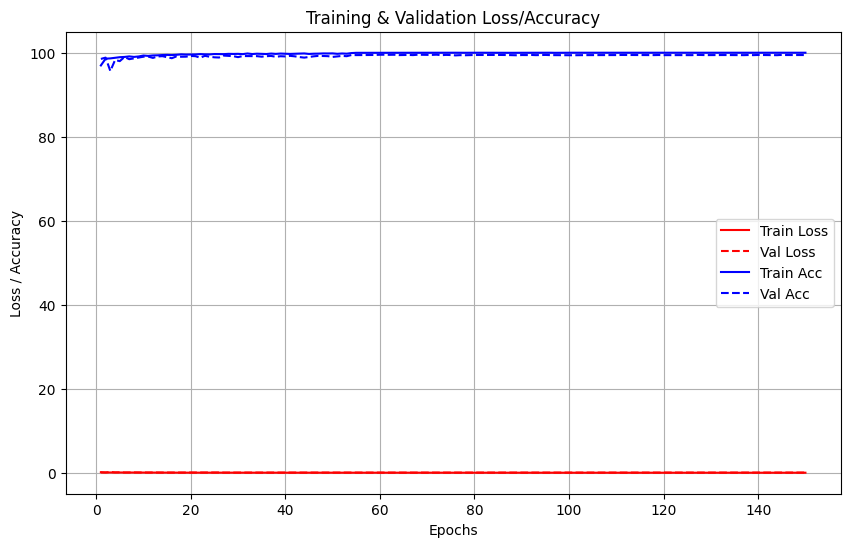

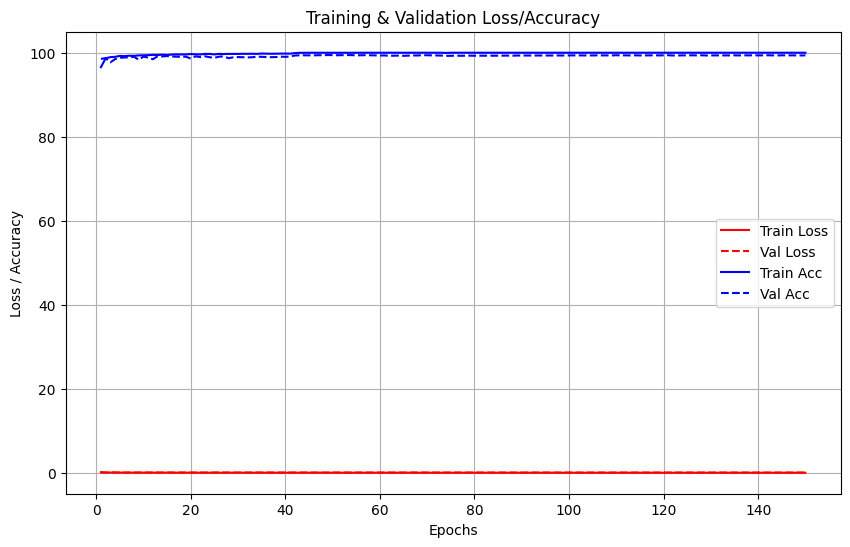

In [ ]:
vgg19_best_model, vgg19_history = train_model(vgg19_model_m, vgg19_optimizer_m, vgg19_scheduler_m,
                                  num_epochs=500, model_path="best_vgg19.pth")

In [ ]:
resnet34_best_model, resnet34_history = train_model(resnet34_model_m, resnet34_optimizer_m, resnet34_scheduler_m,
                                  num_epochs=500, model_path="best_resnet34.pth")

In [ ]:
plot_history(vgg19_history)

In [ ]:
plot_history(resnet34_history)

### Stage 2. Optimization of Class-specific Augmentation Polices

In [ ]:
# Transformation
def rotation_transform(x):
    r_phi = random.uniform(0,90)
    angle = random.uniform(-r_phi,r_phi)
    return r_phi, TF.rotate(x,angle)

def shear_transform(x):
    s_phi = random.uniform(0,45)
    shear = random.uniform(-s_phi,s_phi)
    return s_phi, TF.affine(x, angle=0, translate=(0,0), scale=1.0, shear=[shear,0])

def hshift_transform(x):
    hs_phi = random.uniform(0,50) 
    pixel = int(hs_phi/100 * x.size(-1))
    shift = random.randint(-pixel,pixel)
    return hs_phi, TF.affine(x, angle=0, translate=(0,shift), scale=1.0, shear=0)

def vshift_transform(x):
    vs_phi = random.uniform(0,50)
    pixel = int(vs_phi/100 * x.size(-2))
    shift = random.randint(-pixel,pixel)
    return vs_phi, TF.affine(x, angle=0, translate=(0,shift), scale=1.0, shear=0)

def zoom_transform(x):
    z_phi = random.uniform(0,50)
    factor = 1 + random.uniform(-z_phi/100,z_phi/100)
    w,h = x.size(-1), x.size(-2)
    return z_phi, TF.resize(TF.center_crop(x, (int(h/factor), int(w/factor))), (h,w))

def brightness(x):
    b_phi = random.uniform(0,50)
    factor = 1 + random.uniform(-b_phi/100,b_phi/100)
    return b_phi, TF.adjust_brightness(x,factor)

def contrast_transform(x):
    c_phi = random.uniform(0,50)
    factor = 1 + random.uniform(-c_phi,100,c_phi/100)
    return c_phi, TF.adjust_contrast(x,factor)

def colorinvert_transform(x):
    i_phi = random.choice([0,0.5])
    if i_phi == 0.5:
        return TF.invert(x)
    return i_phi, x

def hflip_transform(x):
    hf_phi = random.choice([0,0.5])
    if hf_phi == 0.5:
        return TF.hflip(x)
    return hf_phi, x

def vflip_transform(x):
    vf_phi = random.choice([0,0.5])
    if vf_phi == 0.5:
        return TF.vflip(x)
    return vf_phi, x

In [ ]:
import torch.nn.functional as F
# m in [1,7], continuous hyperparameter

def delta_m_c(model, loader, transform, phi, device="cuda"):
    model.eval()
    difference = []
    with torch.no_grad():
        for X, _ in loader:
            X = X.to(device)
            p = F.softmax(model(X), dim=1)

            pos = transform(X, phi)
            neg = transform(X,-phi)

            pos_p = F.softmax(model(pos.to(device)), dim=1)
            neg_p = F.softmax(model(neg.to(device)), dim=1)

            diff = torch.abs(pos_p - p).sum(dim=1) + torch.abs(neg_p-p).sum(dim=1)
            difference.append(diff)
    
    return (torch.cat(difference).mean()/2).item()


# m in [8,10], discrete hyperparameter with value 0, 0.5

def delta_m_d(model, loader, transform, phi, device="cuda"):
    model.eval()
    difference = []
    with torch.no_grad():
        for X, _ in loader:
            X = X.to(device)
            p = F.softmax(model(X), dim=1)

            if phi == 0:
                transform_p = p
            else:
                transform_X = transform(X)
                transform_p = F.softmax(model(transform_X.to(device)), dim=1)

            diff = torch.abs(transform_p - p).sum(dim=1)
            difference.append(diff)
    
    return torch.cat(difference).mean().item()

In [ ]:
# objective

def objective(type, model, loader, transform, phi, u_m, epsilon=0.1, la=0.01):
    if type == "c":
        delta = delta_m_c(model, loader, transform, phi)
    else:
        delta = delta_m_d(model, loader, transform, phi)
    
    penalty = min(epsilon - delta, 0)
    preference = la*(phi/u_m)

    return penalty + preference

In [ ]:
from skopt import gp_minimize
from skopt.space import Real

# optimization
# minimize problem으로 변환

def optimization_c(model, loader, transform, u_m, epsilon=0.1, la=0.01):
    
    def obj(x):
        return -objective("c", model, loader, transform, x[0], u_m, epsilon, la)
    
    res = gp_minimize(
        obj,
        dimensions=[Real(0, u_m, name="phi")],
        n_calls=30,
        n_random_starts=5,
        random_state=42
    )
    
    return res.x[0], -res.fun

def optimization_d(model, loader, transform, phi, u_m, epsilon=0.1, la=0.01):
    
    params = [0,0.5]
    scores = [(phi, objective("d", model, loader, transform, phi, u_m, epsilon, la)) for phi in params]
    
    return max(scores, key=lambda x: x[1])

In [ ]:
# 클래스 별로 분리
def c_subset(dataset, num_class, batch_size=128, shuffle=True):
    class_subset = {}
    loader_subset = {}

    for c in range(num_class):
        idx = [i for i, (_, label) in enumerate(dataset)]
        class_subset[c] = Subset(dataset, idx)
        loader_subset[c] = DataLoader(class_subset[c], batch_size=batch_size, shuffle=shuffle)
    
    return class_subset, loader_subset

In [ ]:
m_class_subset, m_loader_subset = c_subset(m_valset, len(m_fulltrainset.classes))
vgg19_best_phi_m = []
vgg19_best_score_m = []
resnet34_best_phi_m = []
resnet34_best_score_m = []

# VGG19
vgg19_model_m = VGG19_GAP(num_classes=len(m_fulltrainset.classes))
vgg19_num_ftrs_m = vgg19_model_m.fc.in_features
vgg19_model_m = vgg19_model_m.to(device)
vgg19_model_m.load_state_dict(torch.load("best_vgg19.pth", map_location="cuda"))
vgg19_model_m = vgg19_model_m.to(device)

# ResNet34
resnet34_model_m = ResNet34_mod(num_classes=len(m_fulltrainset.classes))
resnet34_num_ftrs_m = resnet34_model_m.base.fc.in_features
resnet34_model_m = resnet34_model_m.to(device)
resnet34_model_m.load_state_dict(torch.load("best_resnet34.pth", map_location="cuda"))
resnet34_model_m = resnet34_model_m.to(device)

transforms_c = [
    rotation_transform,
    shear_transform,
    hshift_transform,
    vshift_transform,
    zoom_transform,
    brightness,
    contrast_transform
]

transforms_d = [
    colorinvert_transform,
    hflip_transform,
    vflip_transform
]

u_m_c = [90, 45, 50, 50, 50, 50, 50]   # 각 continuous transform의 상한값
u_m_d = [0.5, 0.5, 0.5]                # discrete transform은 {0,0.5} 중 선택

for i in range(len(m_fulltrainset.classes)):
    loader = m_loader_subset[i]

    # ---- VGG19 ----
    for t, u_m in zip(transforms_c, u_m_c):
        best_phi, best_score = optimization_c(vgg19_model_m, loader, t, u_m)
        vgg19_best_phi_m.append((i, t.__name__, best_phi))
        vgg19_best_score_m.append((i, t.__name__, best_score))

    for t, u_m in zip(transforms_d, u_m_d):
        best_phi, best_score = optimization_d(vgg19_model_m, loader, t, 0.5, u_m)
        vgg19_best_phi_m.append((i, t.__name__, best_phi))
        vgg19_best_score_m.append((i, t.__name__, best_score))

    # ---- ResNet34 ----
    for t, u_m in zip(transforms_c, u_m_c):
        best_phi, best_score = optimization_c(resnet34_model_m, loader, t, u_m)
        resnet34_best_phi_m.append((i, t.__name__, best_phi))
        resnet34_best_score_m.append((i, t.__name__, best_score))

    for t, u_m in zip(transforms_d, u_m_d):
        best_phi, best_score = optimization_d(resnet34_model_m, loader, t, 0.5, u_m)
        resnet34_best_phi_m.append((i, t.__name__, best_phi))
        resnet34_best_score_m.append((i, t.__name__, best_score))


# 결과 출력 예시
for phi, score in zip(vgg19_best_phi_m, vgg19_best_score_m):
    print(phi, score)

for phi, score in zip(resnet34_best_phi_m, resnet34_best_score_m):
    print(phi, score)

### Stage 3. Training with Class-Adaptive Data Augmentation